In [17]:
#import required Python Packages
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
                     

In [36]:
#define a softmax function which is used for explore and exploit feature in RL
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

Environmet proviedes all the required information to the RL agent. Defining a Environment is very important and usually its done by the SME's

In [23]:
#Creating a environment class for our Ad Placement problem.
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [26]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [60]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

1


In [29]:

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [30]:
loss_fn = torch.nn.MSELoss()

In [31]:
env = ContextBandit(arms)

In [32]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [33]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [42]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms,env.get_state())) #A
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state) #B
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) #C
        av_softmax /= av_softmax.sum() #D
        choice = np.random.choice(arms, p=av_softmax) #E
        cur_reward = env.choose_arm(choice) #F
        one_hot_reward = y_pred.data.numpy().copy() #G
        one_hot_reward[choice] = cur_reward #H
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms,env.get_state())) #I
    return np.array(rewards),cur_state

In [43]:
rewards,state = train(env)

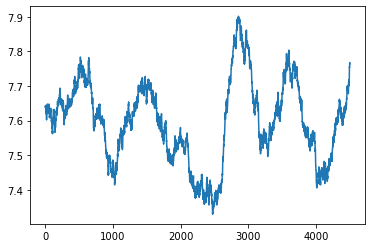

In [44]:
plt.plot(running_mean(rewards,N=500))

In [45]:
len(rewards)

5000

In [76]:
env = ContextBandit(arms=10)
state = torch.Tensor(one_hot(arms,env.get_state()))

In [77]:
state

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [78]:
y_pred = model(state)

In [79]:
y_pred

tensor([ 8.1739,  4.6165,  6.3213,  0.0000,  8.6775, 10.3853,  2.4840,  6.8978,
         0.0000,  0.0000], grad_fn=<ReluBackward0>)

In [80]:
av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
av_softmax /= av_softmax.sum()

In [81]:
av_softmax

array([0.15362333, 0.02593987, 0.06083732, 0.00257939, 0.197609  ,
       0.46415806, 0.00893128, 0.08116291, 0.00257939, 0.00257939],
      dtype=float32)

In [82]:
choice = np.random.choice(arms, p=av_softmax)
choice

7

In [83]:
cur_reward = env.choose_arm(choice)
cur_reward

9